In [60]:
from ipynb.fs.full.Mimic import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import tree

import warnings
warnings.filterwarnings("ignore")

# Evaluation Methodology

In [2]:
# # initialize file
# f = open("Results/exp_predictionAcc_realData.txt", "w") # a is append, w is write
# f.write("DS,rep,clf,optimal,biased,method,augmented_acc,added_points")
# f.close()

In [2]:
def augment_multiClass_imi(data, labels):
    points = []
    point_labels = []
    for c in np.unique(labels):
        #dev = np.std(data[labels==c], axis=0)
        #aug_p, _ = Imitate_augment(data[labels==c][:,dev>0], np.array([0]*np.sum(labels==c)))
        aug_p, _ = Imitate_augment(data[labels==c], np.array([0]*np.sum(labels==c)))
        #if len(aug_p) == 0: continue
        #for col in np.where(dev==0)[0]:
        #    aug_p = np.insert(aug_p, col, data[labels==c][0, col], axis=1)
        points.append(aug_p)
        point_labels.append([c]*len(aug_p))
    return np.concatenate(points), np.concatenate(point_labels)

In [3]:
def augment_multiClass_gmm(data, labels):
    points = []
    point_labels = []
    for c in np.unique(labels):
        dev = np.std(data[labels==c], axis=0)
        gm_params = fit_gmm(data[labels==c][:,dev>0])
        try:
            aug_p, _ = augment(data[labels==c][:,dev>0], gm_params, plots=False, purge=False)
            for col in np.where(dev==0)[0]:
                aug_p = np.insert(aug_p, col, data[labels==c][0, col], axis=1)
            points.append(aug_p)
            point_labels.append([c]*len(aug_p))
        except:
            continue
    if len(points) == 0: return np.empty((0, len(data[0]))), point_labels
    return np.concatenate(points), np.concatenate(point_labels)

In [4]:
# if we select the number of components via bic
def fit_gmm(data, max_clusters=20):
    max_clusters = min(len(data)-1, max_clusters)
    best_bic = np.Inf
    for c in range(1, max_clusters):
        gm = GaussianMixture(n_components=c, random_state=0).fit(data)
        if gm.bic(data) < best_bic: 
            best_comp = c
            best_bic = gm.bic(data)

    gm = GaussianMixture(n_components=best_comp, random_state=0).fit(data)
    return list(zip(gm.means_, gm.covariances_))

In [5]:
def augment_multiClass_mimic(data, labels):
    points = []
    point_labels = []
    for c in np.unique(labels):
        dev = np.std(data[labels==c], axis=0)
        _, imi_params = fit(data[labels==c][:,dev>0], plots=False)
        try:
            aug_p, _ = augment(data[labels==c][:,dev>0], imi_params, plots=False, purge=False)
            for col in np.where(dev==0)[0]:
                aug_p = np.insert(aug_p, col, data[labels==c][0, col], axis=1)
            points.append(aug_p)
            point_labels.append([c]*len(aug_p))
        except:
            continue
    if len(points) == 0: return np.empty((0, len(data[0]))), point_labels
    return np.concatenate(points), np.concatenate(point_labels)

In [6]:
def run_experiment(X, y, bias_gen, ds="", rep=10):
    clf_names = ['DT', 'SVM', 'RF']
    for r in range(rep):
        clfs = [DecisionTreeClassifier(), SVC(), RandomForestClassifier()]
        X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.20)
        X_b, y_b = bias_gen(X_tr, y_tr)
        X_te = X_te[:,:-1]
        X_tr = X_tr[:,:-1]
        
        p_gmm, l_gmm = augment_multiClass_gmm(X_b, y_b)
        X_gmm, y_gmm = np.concatenate((X_b, p_gmm)), np.append(y_b, l_gmm)
        
        p_imi, l_imi = augment_multiClass_imi(X_b, y_b)
        X_imi, y_imi = np.concatenate((X_b, p_imi)), np.append(y_b, l_imi)
        
        p_mim, l_mim = augment_multiClass_mimic(X_b, y_b)
        X_mim, y_mim = np.concatenate((X_b, p_mim)), np.append(y_b, l_mim)
        
        f = open("Results/exp_predictionAcc_realData.txt", "a")
        for i in range(len(clfs)):
            o = clfs[i].fit(X_tr, y_tr).score(X_te, y_te) # original
            b = clfs[i].fit(X_b, y_b).score(X_te, y_te) # biased
            a_gmm = clfs[i].fit(X_gmm, y_gmm).score(X_te, y_te)
            a_imi = clfs[i].fit(X_imi, y_imi).score(X_te, y_te)
            a_mim = clfs[i].fit(X_mim, y_mim).score(X_te, y_te)

            f.write("\n"+ds+","+str(r)+","+clf_names[i]+","+str(o)+","+str(b)+",GMM,"+str(a_gmm)+","+str(len(l_gmm)))
            f.write("\n"+ds+","+str(r)+","+clf_names[i]+","+str(o)+","+str(b)+",Imitate,"+str(a_imi)+","+str(len(l_imi)))
            f.write("\n"+ds+","+str(r)+","+clf_names[i]+","+str(o)+","+str(b)+",Mimic (ours),"+str(a_mim)+","+str(len(l_mim)))
        f.close()

# Abalone
(taken from Imitate paper)

In [56]:
# class label = sex
def loadData_abalone(dataset_size=4177):
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data'
    dataset = pd.read_csv(url, header=None)
    y = dataset[0].to_numpy()
    isInB = np.array([dataset.to_numpy()[i,6]<0.144 for i in range(len(dataset))])
    isInB = isInB.reshape(len(isInB), 1)
    X = dataset.drop([0], axis=1).to_numpy()
    X = np.append(X, isInB, axis=1)
    
    return X, y

In [57]:
def bias_abalone(data, labels):
    isInB = data[:,-1]
    X = data[isInB==1]
    X = X[:, 0:(len(data[0])-1)]
    y = labels[isInB==1]
    return X, y

In [58]:
X, y = loadData_abalone()

In [59]:
#run_experiment(X, y, bias_abalone, ds='Abalone', rep=10)

# Banknote
(taken from Imitate paper)

In [19]:
def loadData_banknote_complete(dataset_size=1372):
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt'
    dataset = pd.read_csv(url, header=None)
    y = dataset[4].to_numpy()
    isInB = np.array([dataset.to_numpy()[i,0]>0.32 for i in range(len(dataset))])
    isInB = isInB.reshape(len(isInB), 1)
    X = dataset.drop([4], axis=1).to_numpy()
    X = np.append(X, isInB, axis=1)
    
    return X, y

In [20]:
def bias_banknote(data, labels):
    isInB = data[:,-1]
    X = data[isInB==1]
    X = X[:, 0:(len(data[0])-1)]
    y = labels[isInB==1]
    return X, y

In [21]:
X, y = loadData_banknote_complete()

In [22]:
#run_experiment(X, y, bias_banknote, ds='Banknote', rep=20)

# Car
(taken from Imitate paper)

In [23]:
def loadData_car(dataset_size=1728):
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data'
    toNum = {
        'low': 1,
        'med': 2,
        'high': 3,
        'vhigh':4,
        '5more':5,
        'more':5,
        'small':1,
        'big':3
    }
    dataset = pd.read_csv(url, header=None)
    y = dataset[6].to_numpy()
    dataset = dataset.drop([6], axis=1)
    dataset = dataset.replace({0:toNum, 1:toNum, 2:toNum, 3:toNum, 4:toNum, 5:toNum})
    dataset = dataset.apply(pd.to_numeric)
    
    isInB = np.array([dataset.to_numpy()[i,3]>3 for i in range(len(dataset))])
    isInB = isInB.reshape(len(isInB), 1)
    #dataset = dataset.drop([3], axis=1)
    X = np.append(dataset.to_numpy(), isInB, axis=1)
    
    return X, y

In [24]:
def bias_car(data, labels):
    isInB = data[:,-1]
    X = data[isInB==1]
    X = X[:, 0:(len(data[0])-1)]
    y = labels[isInB==1]
    return X, y

In [25]:
X, y = loadData_car()

In [61]:
#run_experiment(X, y, bias_car, ds='Car', rep=20)

# Skin
(taken from Imitate paper)

In [28]:
def loadData_skin(dataset_size=245057):
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00229/Skin_NonSkin.txt'
    dataset = pd.read_csv(url, header=None, sep='\t')
    y = dataset[3].to_numpy()
    isInB = np.array([dataset.to_numpy()[i,2]<=170.5 for i in range(len(dataset))])
    isInB = isInB.reshape(len(isInB), 1)
    X = dataset.drop([3], axis=1).to_numpy()
    X = np.append(X, isInB, axis=1)
    
    # draw sample
    X, _, y, _ = train_test_split(X, y, test_size=0.98)
    
    return X, y

In [29]:
def bias_skin(data, labels):
    isInB = data[:,-1]
    X = data[isInB==1]
    X = X[:, 0:(len(data[0])-1)]
    y = labels[isInB==1]
    return X, y

In [30]:
X, y = loadData_skin()

In [31]:
#run_experiment(X, y, bias_skin, ds='Skin', rep=10)

## Wholesale customers
https://archive.ics.uci.edu/ml/datasets/Wholesale+customers

In [38]:
df = pd.read_csv("Datasets/Wholesale_customers_data.csv")
channel = df['Channel']
region = df['Region']
X = df.drop(['Channel', 'Region'], axis=1).to_numpy()
isInB = (df['Frozen'] > 409.5).to_numpy()

[Text(167.4, 163.07999999999998, 'X[3] <= 409.5\ngini = 0.442\nsamples = 440\nvalue = [77, 47, 316]'),
 Text(83.7, 54.360000000000014, 'gini = 0.229\nsamples = 63\nvalue = [5, 3, 55]'),
 Text(251.10000000000002, 54.360000000000014, 'gini = 0.471\nsamples = 377\nvalue = [72, 44, 261]')]

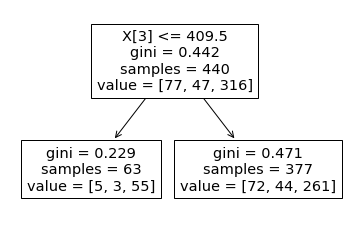

In [107]:
clf = tree.DecisionTreeClassifier(max_depth=1)
clf = clf.fit(X,region)
tree.plot_tree(clf)

In [39]:
def loadData_wholesale(dataset_size=440):
    df = pd.read_csv("Datasets/Wholesale_customers_data.csv")
    df['isInB'] = df['Frozen'] > 409.5
    y = df['Region']
    X = df.drop(['Channel', 'Region'], axis=1).astype(float).to_numpy()
    
    return X, y

In [40]:
def bias_wholesale(data, labels):
    isInB = data[:,-1]
    X = data[isInB==1][:, 0:-1]
    y = labels[isInB==1]
    return X, y

In [41]:
X, y = loadData_wholesale()

In [42]:
#run_experiment(X, y, bias_wholesale, ds='Wholesale', rep=20)

## Diabetes
https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008

In [48]:
df = pd.read_csv("Datasets/diabetic_data.csv", sep=",", header=0)
race = df['race']
gender = df['gender']
med = df['diabetesMed']
df['age_num'] = pd.factorize(df['age'], sort=True)[0]*10+5
age = df['age_num']
cols = ['num_lab_procedures', 'num_procedures', 'num_medications', 'age_num',
        'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']
X, _, y, _ = train_test_split(df[cols], med, test_size=0.9, stratify=med)
X = X.to_numpy()
isInB = X[:,2] > 9.5

[Text(167.4, 163.07999999999998, 'X[2] <= 9.5\ngini = 0.354\nsamples = 10176\nvalue = [2340, 7836]'),
 Text(83.7, 54.360000000000014, 'gini = 0.473\nsamples = 2010\nvalue = [771, 1239]'),
 Text(251.10000000000002, 54.360000000000014, 'gini = 0.31\nsamples = 8166\nvalue = [1569, 6597]')]

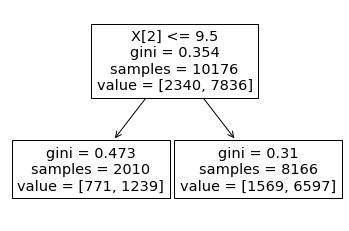

In [46]:
clf = tree.DecisionTreeClassifier(max_depth=1)
clf = clf.fit(X,y)
tree.plot_tree(clf)

In [43]:
def loadData_diabetes(dataset_size=440):
    df = pd.read_csv("Datasets/diabetic_data.csv", sep=",", header=0)
    df['age_num'] = pd.factorize(df['age'], sort=True)[0]*10+5
    cols = ['num_lab_procedures', 'num_procedures', 'num_medications', 'age_num',
            'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']
    X, _, y, _ = train_test_split(df[cols], df['diabetesMed'], test_size=0.9, stratify=df['diabetesMed'])
    X = X.to_numpy()
    isInB = X[:,2] > 9.5
    X = np.column_stack(((X, isInB.astype(int))))
    
    return X, y

In [44]:
def bias_diabetes(data, labels):
    isInB = data[:,-1]
    X = data[isInB==1][:, 0:-1]
    y = labels[isInB==1]
    return X, y

In [45]:
X, y = loadData_diabetes()

In [46]:
#run_experiment(X, y, bias_diabetes, ds='Diabetes', rep=20)

# Vertebral Column
https://archive.ics.uci.edu/ml/datasets/Vertebral+Column

In [47]:
df = pd.read_csv('Datasets/column_2C.dat', sep='\s', header=None)
y = df[6]
X = df.drop([6], axis=1).to_numpy()
isInB = X[:,5] <= 14.855

[Text(167.4, 163.07999999999998, 'X[5] <= 14.855\ngini = 0.437\nsamples = 310\nvalue = [210, 100]'),
 Text(83.7, 54.360000000000014, 'gini = 0.479\nsamples = 161\nvalue = [64, 97]'),
 Text(251.10000000000002, 54.360000000000014, 'gini = 0.039\nsamples = 149\nvalue = [146, 3]')]

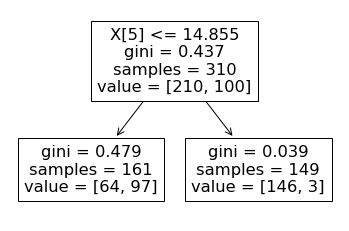

In [65]:
clf = tree.DecisionTreeClassifier(max_depth=1)
clf = clf.fit(X,y)
tree.plot_tree(clf)

In [48]:
def loadData_vertebral(dataset_size=310):
    df = pd.read_csv('Datasets/column_2C.dat', sep='\s', header=None)
    y = df[6]
    X = df.drop([6], axis=1).to_numpy()
    isInB = X[:,5] <= 14.855
    X = np.column_stack(((X, isInB.astype(int))))
    
    return X, y

In [49]:
def bias_vertebral(data, labels):
    isInB = data[:,-1]
    X = data[isInB==1][:, 0:-1]
    y = labels[isInB==1]
    return X, y

In [50]:
X, y = loadData_vertebral()

In [51]:
#run_experiment(X, y, bias_vertebral, ds='Vertebral Column', rep=20)

# Yeast
https://archive.ics.uci.edu/ml/datasets/Yeast

In [8]:
df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/yeast/yeast.data", header=None, sep='\s+')
y = (df[9] == 'CYT').astype(int)
X = df.drop([0, 9], axis=1).to_numpy()
isInB = X[:,2] > 0.445

[Text(167.4, 163.07999999999998, 'X[2] <= 0.445\ngini = 0.429\nsamples = 1484\nvalue = [1021, 463]'),
 Text(83.7, 54.360000000000014, 'gini = 0.083\nsamples = 322\nvalue = [308, 14]'),
 Text(251.10000000000002, 54.360000000000014, 'gini = 0.474\nsamples = 1162\nvalue = [713, 449]')]

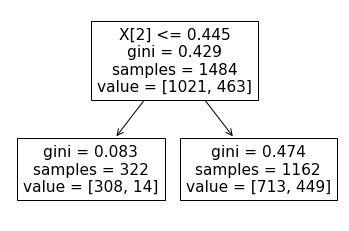

In [9]:
clf = tree.DecisionTreeClassifier(max_depth=1)
clf = clf.fit(X,y)
tree.plot_tree(clf)

In [10]:
quick_test(X, y, isInB, rep=3)

DT GMM -0.014150943396226467
DT Imi -0.09029649595687339
DT Mimic 0.0
DT MAX 0.07345013477088946
Mimic wins!
SVM GMM -0.028301886792452824
SVM Imi -0.013477088948787075
SVM Mimic -0.010781671159029727
SVM MAX 0.02156334231805923
Mimic wins!
RF GMM -0.025606469002695476
RF Imi -0.1671159029649596
RF Mimic -0.025606469002695476
RF MAX 0.025606469002695365
------------------------------
DT GMM 0.008760107816711549
DT Imi 0.004716981132075415
DT Mimic -0.011455525606469008
DT MAX 0.0768194070080862
SVM GMM -0.0006738544474393926
SVM Imi -0.0013477088948787852
SVM Mimic 0.0
SVM MAX 0.02156334231805923
Mimic wins!
RF GMM 0.0040431266846360225
RF Imi -0.016846361185983927
RF Mimic -0.01482479784366586
RF MAX 0.025606469002695365
------------------------------
DT GMM -0.0026954177897574594
DT Imi 0.0040431266846361336
DT Mimic -0.0020215633423180668
DT MAX 0.0714285714285714
SVM GMM -0.055929919137466366
SVM Imi -0.0074123989218328745
SVM Mimic 0.0026954177897573484
SVM MAX 0.02156334231805923

In [52]:
def loadData_yeast(dataset_size=1484):
    df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/yeast/yeast.data", header=None, sep='\s+')
    y = (df[9] == 'CYT').astype(int)
    X = df.drop([0, 9], axis=1).to_numpy()
    isInB = X[:,2] > 0.445
    X = np.column_stack(((X, isInB.astype(int))))
    
    return X, y

In [53]:
def bias_yeast(data, labels):
    isInB = data[:,-1]
    X = data[isInB==1][:, 0:-1]
    y = labels[isInB==1]
    return X, y

In [54]:
X, y = loadData_yeast()

In [55]:
run_experiment(X, y, bias_yeast, ds='Yeast', rep=20)